In this version, we've moved almost all the glove calibration code into another file, `util/glove.py`, which Python will now treat as a module called `util.glove` from which we can import functions. (Importantly, these functions' definitions all include docstrings to tell you how they're meant to be called from a main script like this one -- check out `util/glove.py`.)

A primer on modules: Python will treat any `.py` file as a module from which things can be imported, _or_ any folder that contains a file called `__init__.py` (which can be empty or not -- it's just there to tell Python that the folder should be treated as a module). If you put a module _inside_ of another module, then it becomes a submodule. So our `util.glove` is a submodule of `util`, since we've added file `util/glove.py` to the folder `util`, which contains `util/__init__.py`. 

This is handy because we can have one `util` module that contains all our helper code, but we can subdivide `util` into different submodules containing functions that go together in some way. I tend to think of these groupings as "if it would be hard to imagine a project where I would use function _p_ without also using function _q_ and vice versa, then _p_ and _q_ probably belong in the same submodule." Groups of functions that might be used seperately from one another get their own submodules. That way, I can drag and drop submodules between projects with minimal friction, which makes it easy to reuse code. 

For instance, our `util` module also contains a `util.bids` submodule (which we actually imported from in `v1`), which contains a helper class for organizing BIDS derivatives directories. This helper wouldn't logically be grouped with glove-related functions (there are plenty of projects in which I save BIDS-formatted derivatives but don't use this damn glove), so it gets a seperate module. 

In [1]:
from util.glove import load_joint_angles # <-- our custom module!
from bids import BIDSLayout
import numpy as np

DATA_DIR = 'bids_pilot'
SUBJECT = '01'
RUN = 1

Now, all we need to do to load the predicted joint angles for a task run is the following, which will load an existing calibration if one has already been computed and will compute a new one otherwise:

In [2]:
layout = BIDSLayout(DATA_DIR, derivatives = True)
joint_angles, t, sfreq = load_joint_angles(layout, SUBJECT, RUN, True)
joint_angles.head()

Didn't find pre-computed glove calibration for sub-01...
Computing one now from calibration data.


,cmc_abduction,cmc_flexion,mp_flexion,ip_flexion,mcp2_flexion,mcp2_abduction,pm2_flexion,md2_flexion,mcp3_flexion,mcp3_abduction,pm3_flexion,md3_flexion,mcp4_flexion,mcp4_abduction,pm4_flexion,md4_flexion,mcp5_flexion,mcp5_abduction,pm5_flexion,md5_flexion
0,-0.128878,0.607248,-0.176818,-0.306598,0.269973,0.061624,0.353702,0.200088,0.493427,0.047549,0.648273,0.418880,0.422592,0.010576,0.506757,0.382832,0.320921,-0.080722,0.576247,0.543222
1,-0.131329,0.605881,-0.179560,-0.310624,0.282683,0.064589,0.359448,0.202354,0.495324,0.047799,0.644620,0.417699,0.442521,0.008167,0.530573,0.391684,0.336595,-0.084165,0.586544,0.552862
2,-0.130608,0.607734,-0.177465,-0.307696,0.276153,0.063166,0.356036,0.201029,0.490889,0.047017,0.644646,0.417921,0.430642,0.009211,0.517483,0.386488,0.330066,-0.081677,0.583132,0.548859
3,-0.132202,0.607480,-0.180733,-0.312326,0.288608,0.066127,0.365134,0.205014,0.498672,0.048195,0.649746,0.419458,0.440549,0.008493,0.531145,0.390626,0.335654,-0.083081,0.588302,0.551514
4,-0.128288,0.606467,-0.175150,-0.306173,0.279368,0.064133,0.357113,0.201378,0.495848,0.048103,0.647492,0.418559,0.442857,0.008270,0.529266,0.390597,0.333942,-0.083908,0.583095,0.550263


And that's really all we want... reading in the joint angles is now as simple as reading in any other data we've recorded. 

However, we also don't want to use valuable quality check metrics, so our "hidden" implementation does still store cross-validation scores for each calibration. These are automatically saved into a JSON file when the model is computed. We can retrieve this information easily, since derivatives of the original data are stored in BIDS format as well:

In [3]:
layout.get(subject = SUBJECT, suffix = 'r2')[0].get_dict()

{'cmc_flexion': 0.713169896105156,
 'cmc_abduction': 0.2451721012121323,
 'mp_flexion': 0.7611847084531176,
 'ip_flexion': 0.7421283746024221,
 'mcp2_flexion': 0.7230714064789039,
 'mcp2_abduction': 0.6664999286580509,
 'pm2_flexion': 0.7027018999257733,
 'md2_flexion': 0.7122796884785508,
 'mcp3_flexion': 0.6826422529316001,
 'mcp3_abduction': 0.80765689670941,
 'pm3_flexion': 0.5556490715657092,
 'md3_flexion': 0.6179342660012433,
 'mcp4_flexion': 0.9060473821532942,
 'mcp4_abduction': 0.22401455417932303,
 'pm4_flexion': 0.8906578488026421,
 'md4_flexion': 0.8237009343670134,
 'mcp5_flexion': 0.932362756468528,
 'mcp5_abduction': 0.8105160578123469,
 'pm5_flexion': 0.8730844299962809,
 'md5_flexion': 0.7822042806546046}

Or, of course, they can just be read from the JSON files, which are plain text. Not _everything_ needs to be done in Python.

If we want, we can import other functions from `util.glove` to easily generate some of the same intermediate products we visualized in `v1`.

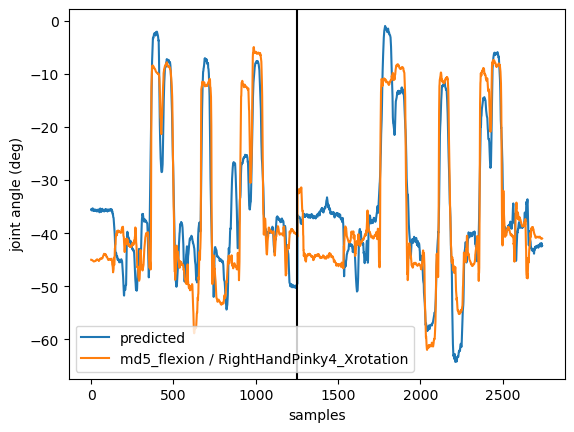

In [4]:
from sklearn.model_selection import cross_val_predict, LeaveOneGroupOut
from matplotlib import pyplot as plt
from util.glove import (
    load_calibration_runs, 
    get_calibration,
    joint_map
)

## load the model
glove, joints, runs = load_calibration_runs(layout, SUBJECT)
mapping = get_calibration(layout, SUBJECT)

JOINT = -1

## get out-of-sample predictions for specified joint
y_pred = cross_val_predict(
    mapping, # sklearn will retrain a copy for each CV split
    glove, joints[:, JOINT], groups = runs, 
    cv = LeaveOneGroupOut()
)

## and plot
plt.plot(y_pred, label = 'predicted')
jnt_nm = list(joint_map)[JOINT]
lab = '%s / %s'%(jnt_nm, joint_map[jnt_nm]) 
plt.plot(joints[:, JOINT], label = lab)
plt.ylabel('joint angle (deg)')
plt.xlabel('samples')
run_breaks = np.where(np.diff(runs) != 0)[0]
for brk in run_breaks:
    plt.axvline(brk, color = 'black')
plt.legend()
plt.show()

But we don't _need_ to visualize joint angles vs. predictions every time we access joint angle estimates. Usually, we'll just want to load in joint angles as if we were loading in data. This is, after all, just the first step of our data processing... so we won't want to make hundreds of lines of our main analyis script/notebook just dealing with instrument calibration. 

But we _do_ want that process to be transparent for those who want/need to see the details. In other words, we want all data processing to be in a "glass box," but we often want to put that box away... so we've made sure the function definitions in `util/glove.py` include informative documentation. 